In [1]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import as_strided

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
car_df = pd.read_csv('clean_signals.csv')

car_df['timestamp'] = pd.to_datetime(car_df['timestamp'])

car_df.shape

(1953951, 18)

### Only focus on complete trips for more sophisticated feature engineering

In [3]:
target_cols = [
    'device_id', 'trip_id', 'timestamp', 
    'speed', 'accelerometer'
]

complete_driving_df = car_df[car_df['is_complete'] == True]\
    [target_cols].reset_index(drop=True)

complete_driving_df.head()

,device_id,trip_id,timestamp,speed,accelerometer
0,1,1,2018-01-24 19:48:01,3,0580fc300340fcd8ce00dbcc0000000000000000000000...
1,1,1,2018-01-24 19:48:02,2,0520fc4003b8fed8d506d9cc04dfca02dccbfdd4cffdda...
2,1,1,2018-01-24 19:48:03,0,0568fc1802d802d8d103d4d203dbcafcddc8fdd9cdfddb...
3,1,1,2018-01-24 19:48:04,0,04e8fbf803b005d8c504d5c9ffd7cbfddad205d2ce02d5...
4,1,1,2018-01-24 19:48:05,0,04a0fc10027003d6cc02d6d000d8cd08d9c904d6cb01d5...


### For each complete trip, we only extract the driving period

In [4]:
def extract_driving_period(df):
    
    driving_period_list = list()
    
    for i, ((device_id, trip_id), group_df) in enumerate(df.groupby(['device_id', 'trip_id'])):
        group_df = group_df.reset_index(drop=True)\
            .reset_index()\
            .rename(columns={'index': 'time_step'})

        # Drop the first record to smooth the signals
        group_df = group_df.loc[1:]

        # Fine the time before stopping the card. 
        driving_time_index = group_df[group_df['speed'] > 0]
        time_before_driving = driving_time_index.index.min()
        time_before_stop = driving_time_index.index.max()
        
        # Remove the records of stopping.
        group_df = group_df.loc[np.maximum(0, time_before_driving): time_before_stop]
        
        if ~np.isnan(time_before_stop) and group_df.shape[0] > 50:
            driving_period_list.append(group_df)
            
    return pd.concat(driving_period_list, ignore_index=True)

driving_df = extract_driving_period(complete_driving_df)

In [5]:
driving_df.shape

(6660, 6)

### Decode Accelerometer Hex code

In [6]:
from decoding_acc import decode_acc_hex

decode_acc_hex_df = decode_acc_hex(driving_df['accelerometer'], car_df['speed'])
driving_df.loc[:, 'acc_x'] = decode_acc_hex_df['acc_x'].values
driving_df.loc[:, 'acc_y'] = decode_acc_hex_df['acc_y'].values
driving_df.loc[:, 'acc_z'] = decode_acc_hex_df['acc_z'].values
driving_df = driving_df.drop('accelerometer', axis=1)

Decoding each accelerometer hex code.


100%|██████████████████████████████████████████████████████████████████████████| 6660/6660 [00:00<00:00, 12360.62it/s]
/Users/qirun.chen/Documents/github/levin-vehicle-telematics/decoding_acc.py:73: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  idle_df = decoded_acc_df[idle_index]
Rotating accelerometer signals.: 100%|█████████████████████████████████████████| 6660/6660 [00:00<00:00, 16045.02it/s]


### Explode signals from 1Hz to 25Hz

In [7]:
driving_df = driving_df.explode(['acc_x', 'acc_y', 'acc_z'])

### Aggregated accelerometers into 1Hz

In [8]:
driving_df = driving_df.groupby(['time_step', 'device_id', 'trip_id', 'timestamp', 'speed'])\
                .agg({'acc_x': np.mean, 'acc_y': np.mean, 'acc_z': np.mean})\
                .reset_index()\
                .sort_values(['device_id', 'trip_id', 'timestamp', 'time_step'])

<Figure size 432x288 with 0 Axes>

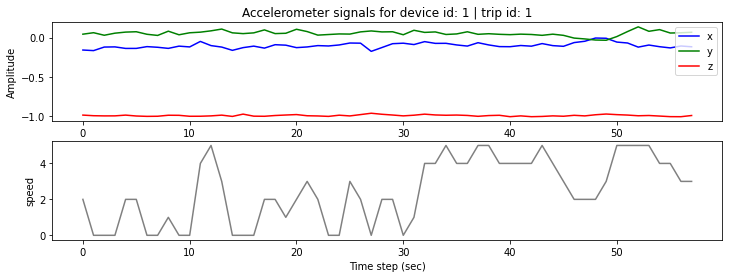

<Figure size 432x288 with 0 Axes>

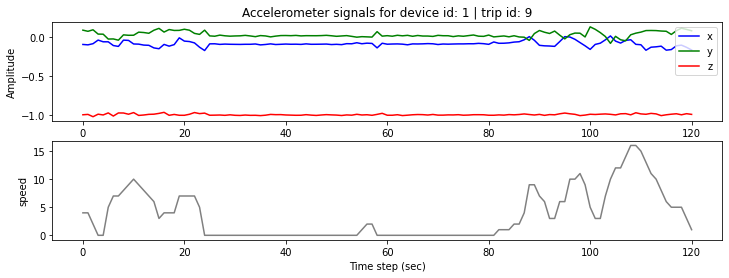

In [9]:
def plot_driving_period(df):
    for i, ((device_id, trip_id), group_df) in enumerate(df.groupby(['device_id', 'trip_id'])):
        group_df = group_df.reset_index(drop=True).reset_index()

        plt.figure()
        _, axes = plt.subplots(2, 1, figsize=(12, 4))
        sns.lineplot(x=group_df['index'], y=group_df['acc_x'], ax=axes[0], color='blue')
        sns.lineplot(x=group_df['index'], y=group_df['acc_y'], ax=axes[0], color='green')
        sns.lineplot(x=group_df['index'], y=group_df['acc_z'], ax=axes[0], color='red')
        axes[0].set_title('Accelerometer signals for device id: {} | trip id: {}'.format(device_id, trip_id))
        axes[0].set_ylabel('Amplitude')
        axes[0].legend(labels=['x', 'y', 'z'], loc='upper right')
        sns.lineplot(x=group_df['index'], y=group_df['speed'], ax=axes[1], color='grey')\
            .set_xlabel('Time step (sec)')
    
        if i == 1: break
        
plot_driving_period(driving_df)

### Driving length distribution
All the driving lengths are longer than 50 seconds. **We can use 50 time steps as a window to build features**.

In [10]:
driving_length = driving_df[['device_id', 'trip_id', 'time_step']]\
    .groupby(['device_id', 'trip_id'])\
    .count()\
    .rename(columns={'time_step': 'driving length (sec)'})['driving length (sec)']

Text(0.5, 1.0, 'Driving length distribution')

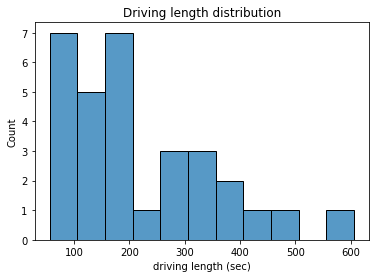

In [11]:
sns.histplot(driving_length, binwidth=50).set_title("Driving length distribution")

### Save out the aggregated data for modelling

In [12]:
driving_df.to_csv('aggregated_acc_signals.csv', index=False)